# ResNet(50)
----

In [218]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import joblib
import math
import random

## Utility Functions
-----

In [219]:
def img_resize(X_data, new_height, new_width, rgb= True):

    # reshape to force X_data to have 4 dimenstions
    X_data = X_data.reshape(X_data.shape[0],X_data.shape[1],X_data.shape[2],-1)

    if rgb == True:
        # force X  to have three channels (RGB)
        X_rgb = np.repeat(X_data, 3, axis=-1) 
    else:
        pass

    # each image stored as single item in list
    resized_images = []
    for i in range(X_rgb.shape[0]):
        resized_image = tf.image.resize(X_rgb[i], size=[new_height,new_width])
        resized_images.append(resized_image)   
    
    # combines list of tensor items to single tensor item new dimenstion = num of images in list 
    X_resized = tf.stack(resized_images)
    
    return X_resized

## Setting up ResNet50
---

In [220]:
from tensorflow.keras.applications import ResNet50

res_model = keras.applications.ResNet50(include_top=False, # Set to false to only load the conv layers, will be swapping out the top layers for ownß
                                     weights='imagenet', 
                                     input_tensor=None,
                                     input_shape=(32,32,3) ,# changing input shape to (32,32,3) 32 is minimium size
                                     pooling=max, # for my output will use pooling
                                     classes= 24, # setting to len of my y (24)
                                     classifier_activation='softmax' # keep as softmax for output layer
                                 )

In [221]:
res_model.trainable = False

### Adding own top layers

In [222]:
my_model = Sequential([res_model,
                       layers.Flatten(),
                       layers.Dense(128, activation='relu'),
                       layers.Dense(64, activation="relu"),
                       layers.Dense(24, activation="softmax")
                       ])

In [223]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               262272    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 24)                1560      
                                                                 
Total params: 23,859,800
Trainable params: 272,088
Non-trainable params: 23,587,712
_________________________________________________________________


In [224]:
my_model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


### Training with MNIST data


In [225]:
X = joblib.load( '../../model/my_files/X.pkl')
y = joblib.load( '../../model/my_files/y.pkl')


In [226]:
X = X.reshape(-1,28,28)
X.shape


(34627, 28, 28)

In [227]:
y.shape

(34627,)

In [228]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)

In [229]:
X_train_resized = img_resize(X_train, 32, 32)
X_val_resized = img_resize(X_val, 32, 32)

In [230]:
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           mode='min',
                           verbose=1)


In [231]:
# Convert y_train to categorical format
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train, num_classes=24)
y_val_cat = to_categorical(y_val, num_classes=24)

In [232]:
y_train_cat

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [233]:
history = my_model.fit(X_train_resized, y_train_cat,
                        batch_size = 128,
                        epochs = 20,
                        verbose = 1,
                        validation_split = 0.2,
                        callbacks=[early_stop])

Epoch 1/20


174/174 [==============================] - 21s 118ms/step - loss: 0.6929 - accuracy: 0.8011 - val_loss: 0.1989 - val_accuracy: 0.9374
Epoch 2/20
174/174 [==============================] - 20s 113ms/step - loss: 0.0723 - accuracy: 0.9861 - val_loss: 0.0472 - val_accuracy: 0.9917
Epoch 3/20
174/174 [==============================] - 20s 117ms/step - loss: 0.0262 - accuracy: 0.9968 - val_loss: 0.0225 - val_accuracy: 0.9964
Epoch 4/20
174/174 [==============================] - 20s 118ms/step - loss: 0.0122 - accuracy: 0.9988 - val_loss: 0.0289 - val_accuracy: 0.9919
Epoch 5/20
174/174 [==============================] - 21s 121ms/step - loss: 0.0081 - accuracy: 0.9993 - val_loss: 0.0095 - val_accuracy: 0.9991
Epoch 6/20
174/174 [==============================] - 20s 117ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0079 - val_accuracy: 0.9982
Epoch 7/20
174/174 [==============================] - 21s 118ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0064 - val_accuracy: 0.9

In [234]:
my_model.save('../../model/my_files/my_ResNet_model.h5')

In [235]:
train_loss, train_acc = my_model.evaluate(X_train_resized, y_train_cat)
print('Train accuracy:', train_acc)

866/866 [==============================] - 91s 105ms/step - loss: 8.1140e-04 - accuracy: 0.9998
Train accuracy: 0.9998195171356201


In [236]:
val_loss, val_acc = my_model.evaluate(X_val_resized, y_val_cat)
print('Val accuracy:', val_acc)

217/217 [==============================] - 22s 100ms/step - loss: 0.0071 - accuracy: 0.9980
Val accuracy: 0.9979786276817322


## Data Augmentation
----

In [237]:
my_model= load_model('../../model/my_files/my_ResNet_model.h5')

In [238]:
train_datagen = joblib.load('../../model/my_files/train_datagen.pkl') 
val_datagen = joblib.load('../../model/my_files/val_datagen.pkl') 

In [239]:
train_generator = train_datagen.flow(X_train_resized, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val_resized, y_val, batch_size=32)

In [240]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
my_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [241]:
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           mode='min',
                           verbose=1)

In [242]:
my_model.fit(train_generator,
              steps_per_epoch=len(train_generator),
              epochs=20,
              validation_data=val_generator,
              validation_steps=len(val_generator),
              callbacks=[early_stop]
    )

Epoch 1/20
866/866 [==============================] - 115s 130ms/step - loss: 3.1519 - accuracy: 0.0737 - val_loss: 2.9954 - val_accuracy: 0.1123
Epoch 2/20
866/866 [==============================] - 111s 128ms/step - loss: 2.9355 - accuracy: 0.1236 - val_loss: 2.7064 - val_accuracy: 0.2164
Epoch 3/20
866/866 [==============================] - 114s 132ms/step - loss: 2.7872 - accuracy: 0.1582 - val_loss: 2.4803 - val_accuracy: 0.2336
Epoch 4/20
866/866 [==============================] - 111s 128ms/step - loss: 2.6964 - accuracy: 0.1866 - val_loss: 2.4265 - val_accuracy: 0.2634
Epoch 5/20
866/866 [==============================] - 112s 129ms/step - loss: 2.6206 - accuracy: 0.2061 - val_loss: 2.2818 - val_accuracy: 0.3127
Epoch 6/20
866/866 [==============================] - 110s 127ms/step - loss: 2.5479 - accuracy: 0.2248 - val_loss: 2.0996 - val_accuracy: 0.3724
Epoch 7/20
866/866 [==============================] - 113s 130ms/step - loss: 2.5116 - accuracy: 0.2314 - val_loss: 2.0615 -

In [59]:
my_model.save('../../model/my_files/my_ResNet_model_AUG.h5')

In [243]:
train_loss, train_acc = my_model.evaluate(train_generator)
print('Train accuracy:', train_acc)

866/866 [==============================] - 56s 64ms/step - loss: 2.5058 - accuracy: 0.2460
Train accuracy: 0.24602000415325165


In [244]:
val_loss, val_acc = my_model.evaluate(val_generator)
print('Val accuracy:', val_acc)

217/217 [==============================] - 18s 81ms/step - loss: 1.8838 - accuracy: 0.3817
Val accuracy: 0.3817499279975891


## Top Up Training using Teachable Machine
----

In [88]:
# load the base VGG model
base_resnet_model = load_model('../../model/my_files/my_ResNet_model.h5')

In [89]:
# unfreeze the base model weights
base_resnet_model.trainable = True

In [90]:
# recompile the model
base_resnet_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

### Get data from TM - should I try augment the data?

In [91]:
directory = '../../model/tm_images/'
my_imgs = keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(32, 32),
    shuffle=True, 
    seed=1
)

Found 2842 files belonging to 23 classes.


In [92]:
train_data, rem_data = keras.utils.split_dataset(my_imgs, right_size= 0.2)
val_data, test_data = keras.utils.split_dataset(rem_data, right_size= 0.1)

In [93]:
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           mode='min',
                           verbose=1)

In [94]:
history = base_resnet_model.fit(train_data,
                        batch_size = 128,
                        epochs = 20, # increasing number of epochs if too high early stopping will stop fitting early, epochs at 10 = poor data 
                        verbose = 1,
                        validation_data = val_data,
                        callbacks=[early_stop])

Epoch 1/100


72/72 [==============================] - 25s 313ms/step - loss: 1.3799 - accuracy: 0.7520 - val_loss: 23.5444 - val_accuracy: 0.2119
Epoch 2/100
72/72 [==============================] - 22s 302ms/step - loss: 1.0289 - accuracy: 0.7661 - val_loss: 5.1722 - val_accuracy: 0.1689
Epoch 3/100
72/72 [==============================] - 22s 302ms/step - loss: 2.6057 - accuracy: 0.2515 - val_loss: 30.5832 - val_accuracy: 0.0884
Epoch 4/100
72/72 [==============================] - 22s 302ms/step - loss: 2.5168 - accuracy: 0.1939 - val_loss: 3.4481 - val_accuracy: 0.0989
Epoch 5/100
72/72 [==============================] - 22s 301ms/step - loss: 2.2187 - accuracy: 0.2498 - val_loss: 3.0668 - val_accuracy: 0.1548
Epoch 6/100
72/72 [==============================] - 22s 302ms/step - loss: 1.7815 - accuracy: 0.3690 - val_loss: 3.8338 - val_accuracy: 0.1071
Epoch 7/100
72/72 [==============================] - 23s 316ms/step - loss: 1.4524 - accuracy: 0.4785 - val_loss: 2.5345 - val_accuracy: 0.1181
Ep

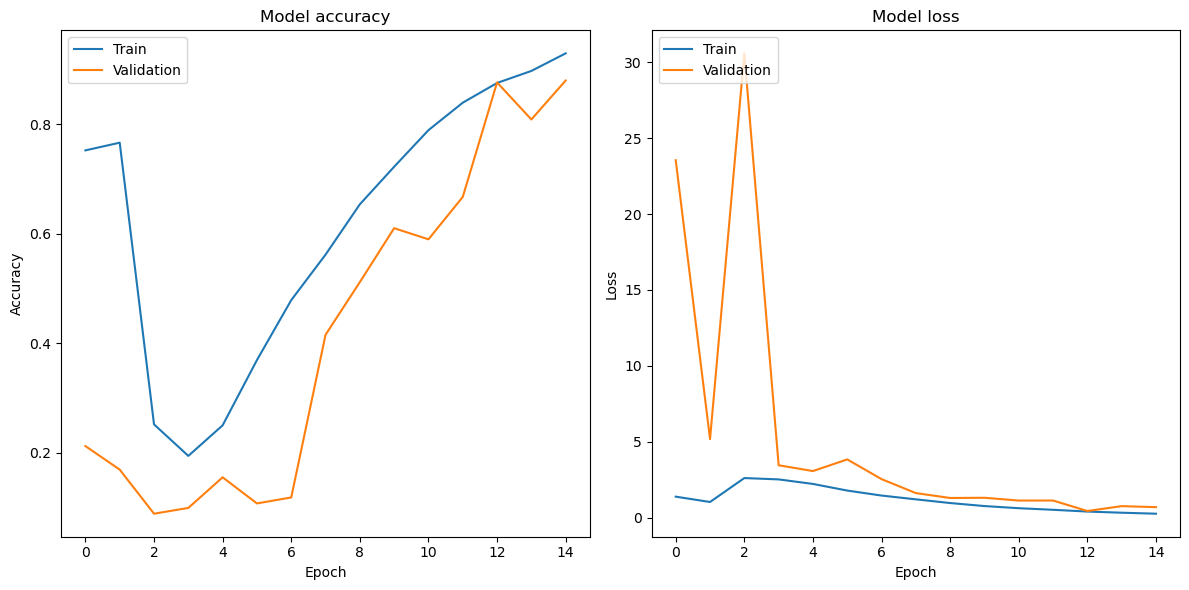

In [95]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# epochs 18

In [96]:
train_loss, train_acc= base_resnet_model.evaluate(train_data)
print('Train accuracy:', train_acc)

72/72 [==============================] - 2s 32ms/step - loss: 0.6854 - accuracy: 0.8799
Train accuracy: 0.8799472451210022


In [97]:
val_loss, val_acc= base_resnet_model.evaluate(val_data)
print('Test accuracy:', val_acc)

80/80 [==============================] - 3s 33ms/step - loss: 0.6897 - accuracy: 0.8796
Test accuracy: 0.8795934319496155


In [98]:
test_loss, test_acc= base_resnet_model.evaluate(test_data)
print('Test accuracy:', test_acc)

9/9 [==============================] - 0s 32ms/step - loss: 0.7130 - accuracy: 0.8662
Test accuracy: 0.8661971688270569


In [99]:
base_resnet_model.save('../../model/my_files/top_up_ResNet.h5')

## Extracting weights and feature maps after top  up training

### Extracting weights

In [4]:
final_resnet = load_model('../../model/my_files/top_up_ResNet.h5')

In [9]:
resnet_layers = final_resnet.layers[0].layers

## FILTER SIZE == 1 

In [42]:
conv_layer_names = []
for layer in resnet_layers:
    print(layer.name)

input_2
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [43]:
conv_layer_names = []
for layer in resnet_layers:
    if isinstance(layer,Conv2D) and '_conv' in layer.name:
        conv_layer_names.append(layer.name)

In [125]:
conv_layer_names

['conv1_conv',
 'conv2_block1_1_conv',
 'conv2_block1_2_conv',
 'conv2_block1_0_conv',
 'conv2_block1_3_conv',
 'conv2_block2_1_conv',
 'conv2_block2_2_conv',
 'conv2_block2_3_conv',
 'conv2_block3_1_conv',
 'conv2_block3_2_conv',
 'conv2_block3_3_conv',
 'conv3_block1_1_conv',
 'conv3_block1_2_conv',
 'conv3_block1_0_conv',
 'conv3_block1_3_conv',
 'conv3_block2_1_conv',
 'conv3_block2_2_conv',
 'conv3_block2_3_conv',
 'conv3_block3_1_conv',
 'conv3_block3_2_conv',
 'conv3_block3_3_conv',
 'conv3_block4_1_conv',
 'conv3_block4_2_conv',
 'conv3_block4_3_conv',
 'conv4_block1_1_conv',
 'conv4_block1_2_conv',
 'conv4_block1_0_conv',
 'conv4_block1_3_conv',
 'conv4_block2_1_conv',
 'conv4_block2_2_conv',
 'conv4_block2_3_conv',
 'conv4_block3_1_conv',
 'conv4_block3_2_conv',
 'conv4_block3_3_conv',
 'conv4_block4_1_conv',
 'conv4_block4_2_conv',
 'conv4_block4_3_conv',
 'conv4_block5_1_conv',
 'conv4_block5_2_conv',
 'conv4_block5_3_conv',
 'conv4_block6_1_conv',
 'conv4_block6_2_conv',
 

In [134]:
layer = final_resnet.layers[0].get_layer('conv2_block2_3_conv')
weights, baises = layer.get_weights()

In [135]:
weights.shape

(1, 1, 64, 256)

In [139]:
conv_model = keras.Model(inputs= final_resnet.layers[0].input, outputs = final_resnet.layers[0].get_layer('conv2_block2_3_conv').output)
conv_model

In [145]:
final_resnet.layers[0].input

<KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'input_2')>

In [166]:
X[0].shape

(784,)

In [181]:
X.shape

(34627, 784)

In [187]:
def get_letter_img (letter):
  X_new = img_resize(X, 32, 32)
  letter_idx = alphabet.index(letter.lower())
  letter_image = tf.reshape(X_new[0], shape=(32, 32, 3))
  return letter_image

In [188]:
def get_conv_layer_ouput(model, layer_name, input_img):

  # force input_img shape to match model input shape
  input_img = tf.reshape(input_img, shape=(-1,32, 32, 3))

  conv_model = keras.Model(inputs= model.input, outputs = model.get_layer(layer_name).output)
  output_conv = conv_model.predict(input_img)

  num_filters = output_conv.shape[-1]
  #output_conv[0,:,:,0] ->  results of first feature map when passed over the first filter

  rows = math.ceil(num_filters/4)

  fig, axes = plt.subplots(rows,4,figsize=(20,4*rows))
  ax = axes.flatten()


  for i in range(num_filters):
    ax[i].imshow(output_conv[0,:,:,i], cmap='viridis')
    ax[i].set_title(f'Filter {i+1} Output', fontsize = '20')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
  plt.show()

1/1 [==============================] - 0s 91ms/step


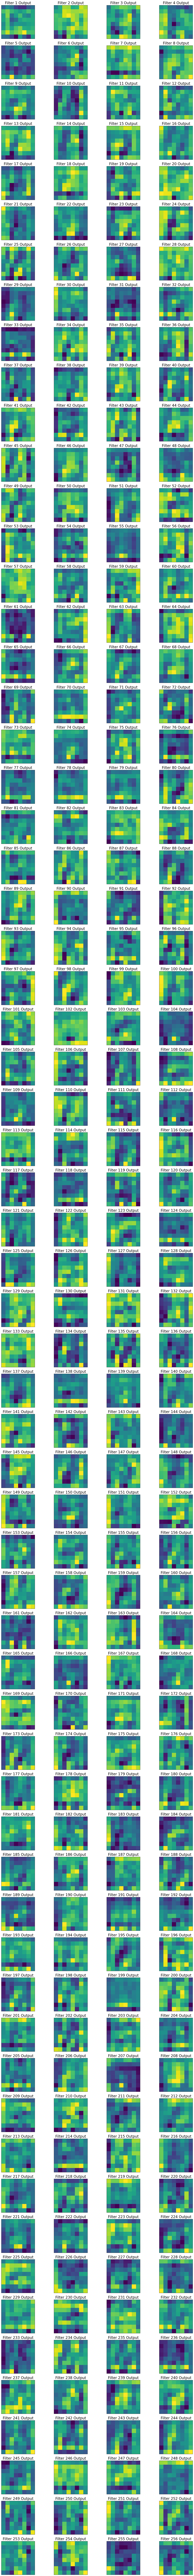

In [189]:
get_conv_layer_ouput(model = final_resnet.layers[0], layer_name = 'conv2_block2_3_conv', input_img = get_letter_img('a') )

In [179]:
conv_model = keras.Model(inputs= final_resnet.layers[0].input, outputs = final_resnet.layers[0].get_layer('conv2_block2_3_conv').output)

In [146]:
test = tf.reshape(X[0], shape=(-1,32, 32, 3))

1/1 [==============================] - 0s 14ms/step


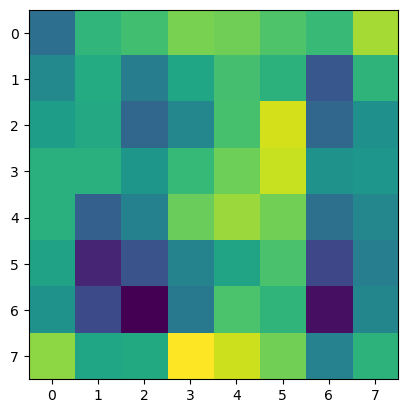

In [152]:
output_conv = conv_model.predict(test)
plt.imshow(output_conv[0,:,:,2])